# CIFAR-100: Baseline vs Stochastic Depth vs DropPath (Aynı Model İçinde)

Bu notebook:
- Aynı model mimarisi (ResNet Bottleneck + SE) ✅
- Aynı data pipeline / optimizer / scheduler ✅
- Sadece residual branch regularization modu değişir:
  - `baseline` (yok)
  - `stochastic_depth` (sample-wise SD)
  - `droppath` (senin DropPath: warmup + layer scaling)

> CIFAR-100 indirmek için internet gerekir (torchvision). GPU önerilir.


In [10]:
# === 0) Imports ===
import os, random, time
from dataclasses import dataclass
from typing import Optional, Literal

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader


In [11]:
# === 1) Seed / Device ===
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 2) Regularization Modülleri (Yorumlar Temiz)

- `StochasticDepth(p)`
- `DropPath(max_drop, layer_idx, num_layers, warmup_steps, batchwise)`


In [12]:
# === 2.1) Stochastic Depth ===
class StochasticDepth(nn.Module):
    def __init__(self, p: float = 0.0):
        super().__init__()
        if not (0.0 <= p < 1.0):
            raise ValueError("p must be in [0,1).")
        self.p = float(p)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if (not self.training) or self.p == 0.0:
            return x
        q = 1.0 - self.p
        shape = (x.size(0),) + (1,) * (x.ndim - 1)
        mask = torch.empty(shape, device=x.device, dtype=x.dtype).bernoulli_(q)
        return x * mask / q


In [13]:
# === 2.2) DropPath (senin versiyon) ===
class DropPath(nn.Module):
    def __init__(
        self,
        max_drop: float = 0.0,
        layer_idx: int | None = None,
        num_layers: int | None = None,
        warmup_steps: int = 0,
        batchwise: bool = True,
        store_mask: bool = False,
    ):
        super().__init__()
        self.max_drop = float(max_drop)
        self.layer_idx = layer_idx
        self.num_layers = num_layers
        self.warmup_steps = int(warmup_steps)
        self.batchwise = bool(batchwise)
        self.store_mask = bool(store_mask)

        self.register_buffer("step", torch.zeros((), dtype=torch.long))
        self.last_mask = None

    def layer_scaled_drop(self) -> float:
        if self.layer_idx is None or self.num_layers is None or self.num_layers <= 1:
            return self.max_drop
        frac = float(self.layer_idx) / float(self.num_layers - 1)
        return self.max_drop * frac

    def warmup_drop_prob(self, drop: float) -> float:
        if self.warmup_steps <= 0:
            return drop
        s = int(self.step.item())
        t = min(max(s / float(self.warmup_steps), 0.0), 1.0)
        return drop * t

    def current_drop_prob(self) -> float:
        d = self.layer_scaled_drop()
        d = self.warmup_drop_prob(d)
        if d < 0.0:
            d = 0.0
        if d >= 1.0:
            d = 0.999
        return d

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            self.step += 1

        drop_prob = self.current_drop_prob()
        if drop_prob <= 0.0 or (not self.training):
            if self.store_mask:
                self.last_mask = None
            return x

        keep_prob = 1.0 - drop_prob
        if self.batchwise:
            mask_shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        else:
            mask_shape = x.shape

        mask = torch.empty(mask_shape, device=x.device, dtype=x.dtype).bernoulli_(keep_prob)
        if self.store_mask:
            self.last_mask = mask.detach()

        return x * mask / keep_prob


## 3) Model: ResNet Bottleneck + SE + (Baseline/SD/DropPath)

Uygulama noktası (adil kıyas):
- Residual branch çıkışında, shortcut eklenmeden hemen önce:
  - `out = regularizer(out)`
  - `out = out + identity`


In [14]:
# === 3) Building Blocks ===
class ConvBNAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, act="silu"):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        self.act = nn.SiLU(inplace=True) if act == "silu" else nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class SEBlock(nn.Module):
    def __init__(self, c: int, r: int = 16, min_hidden: int = 8):
        super().__init__()
        hidden = max(min_hidden, c // r)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(c, hidden, 1, bias=True)
        self.fc2 = nn.Conv2d(hidden, c, 1, bias=True)

    def forward(self, x):
        w = self.pool(x)
        w = F.silu(self.fc1(w), inplace=True)
        w = torch.sigmoid(self.fc2(w))
        return x * w

def linear_probs(total_blocks: int, p_max: float):
    if total_blocks <= 1:
        return [p_max]
    return [p_max * i / (total_blocks - 1) for i in range(total_blocks)]

class BottleneckReg(nn.Module):
    def __init__(
        self,
        cin: int,
        cout: int,
        stride: int = 1,
        expansion: int = 4,
        regularizer: Optional[nn.Module] = None,
        use_se: bool = True,
        act: str = "silu",
    ):
        super().__init__()
        mid = cout // expansion
        assert mid > 0 and cout % expansion == 0, "cout must be divisible by expansion."

        self.conv1 = ConvBNAct(cin, mid, k=1, s=1, p=0, act=act)
        self.conv2 = ConvBNAct(mid, mid, k=3, s=stride, p=1, act=act)
        self.conv3 = nn.Sequential(
            nn.Conv2d(mid, cout, 1, bias=False),
            nn.BatchNorm2d(cout),
        )

        self.se = SEBlock(cout) if use_se else nn.Identity()
        self.reg = regularizer if regularizer is not None else nn.Identity()
        self.act = nn.SiLU(inplace=True) if act == "silu" else nn.ReLU(inplace=True)

        self.shortcut = nn.Identity()
        if stride != 1 or cin != cout:
            self.shortcut = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, bias=False),
                nn.BatchNorm2d(cout)
            )

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.se(out)

        out = self.reg(out)
        out = out + identity
        out = self.act(out)
        return out

class ResNetSECompare(nn.Module):
    def __init__(
        self,
        num_classes: int = 100,
        blocks=(2, 2, 2),
        widths=(64, 128, 256),
        mode: Literal["baseline", "stochastic_depth", "droppath"] = "baseline",
        p_max: float = 0.2,
        droppath_warmup_steps: int = 2000,
        act: str = "silu",
        use_se: bool = True,
    ):
        super().__init__()
        assert len(blocks) == len(widths)

        self.mode = mode
        self.stem = nn.Sequential(
            ConvBNAct(3, 64, k=3, s=1, p=1, act=act),
            ConvBNAct(64, 64, k=3, s=1, p=1, act=act),
        )

        total = sum(blocks)
        probs = linear_probs(total, p_max)
        idx = 0

        in_ch = 64
        stages = []
        for stage_i, (n_blocks, out_ch) in enumerate(zip(blocks, widths)):
            stride = 1 if stage_i == 0 else 2
            for b in range(n_blocks):
                s = stride if b == 0 else 1
                p = probs[idx]
                layer_idx = idx
                idx += 1

                if mode == "baseline":
                    reg = nn.Identity()
                elif mode == "stochastic_depth":
                    reg = StochasticDepth(p)
                elif mode == "droppath":
                    reg = DropPath(
                        max_drop=p_max,
                        layer_idx=layer_idx,
                        num_layers=total,
                        warmup_steps=droppath_warmup_steps,
                        batchwise=True,
                        store_mask=False,
                    )
                else:
                    raise ValueError("mode invalid")

                stages.append(BottleneckReg(in_ch, out_ch, stride=s, regularizer=reg, use_se=use_se, act=act))
                in_ch = out_ch

        self.features = nn.Sequential(*stages)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_ch, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.features(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)


## 4) CIFAR-100 DataLoaders


In [15]:
# === 4) Data ===
@dataclass
class DataCfg:
    root: str = "./data"
    batch_size: int = 128
    num_workers: int = 2

data_cfg = DataCfg()

mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_ds = torchvision.datasets.CIFAR100(root=data_cfg.root, train=True, download=True, transform=train_tf)
test_ds  = torchvision.datasets.CIFAR100(root=data_cfg.root, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=data_cfg.batch_size, shuffle=True, num_workers=data_cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=data_cfg.batch_size, shuffle=False, num_workers=data_cfg.num_workers, pin_memory=True)

len(train_ds), len(test_ds)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## 5) Train / Eval Loop


In [16]:
# === 5) Train/Eval ===
@torch.no_grad()
def accuracy_top1(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if scaler is None:
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = F.cross_entropy(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits.detach(), y) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n


## 6) Deney Runner: 3 Mod (Baseline / SD / DropPath)


In [17]:
# === 6) Runner ===
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class TrainCfg:
    epochs: int = 30
    lr: float = 0.1
    weight_decay: float = 5e-4
    momentum: float = 0.9
    use_amp: bool = True

train_cfg = TrainCfg(epochs=15)

def run_experiment(mode: str, seed: int = 42) -> pd.DataFrame:
    seed_everything(seed)

    model = ResNetSECompare(
        num_classes=100,
        blocks=(2,2,2),
        widths=(64,128,256),
        mode=mode,
        p_max=0.2,
        droppath_warmup_steps=2000,
        act="silu",
        use_se=True,
    ).to(device)

    optimizer = optim.SGD(model.parameters(), lr=train_cfg.lr, momentum=train_cfg.momentum, weight_decay=train_cfg.weight_decay, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_cfg.epochs)
    scaler = torch.cuda.amp.GradScaler() if (train_cfg.use_amp and device == "cuda") else None

    rows = []
    for epoch in range(1, train_cfg.epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler)
        te_loss, te_acc = eval_one_epoch(model, test_loader)
        scheduler.step()

        rows.append({
            "mode": mode,
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "test_loss": te_loss,
            "test_acc": te_acc,
            "lr": scheduler.get_last_lr()[0],
            "sec": time.time() - t0,
        })
        print(f"[{mode}] epoch {epoch:02d}/{train_cfg.epochs} | tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | te_loss={te_loss:.4f} te_acc={te_acc:.4f} | lr={rows[-1]['lr']:.5f}")
    return pd.DataFrame(rows)

modes = ["baseline", "stochastic_depth", "droppath"]


In [18]:
# === 6.1) Koş ve Sonuçları Topla ===
all_df = []
for m in modes:
    df = run_experiment(m, seed=42)
    all_df.append(df)

results = pd.concat(all_df, ignore_index=True)
results.head()


C:\Users\hdgn5\AppData\Local\Temp\ipykernel_16896\3962643168.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (train_cfg.use_amp and device == "cuda") else None
C:\Users\hdgn5\AppData\Local\Temp\ipykernel_16896\490807882.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[baseline] epoch 01/15 | tr_loss=3.7997 tr_acc=0.1109 | te_loss=3.5418 te_acc=0.1547 | lr=0.09891
[baseline] epoch 02/15 | tr_loss=3.1414 tr_acc=0.2203 | te_loss=3.0797 te_acc=0.2328 | lr=0.09568
[baseline] epoch 03/15 | tr_loss=2.7389 tr_acc=0.2965 | te_loss=2.8237 te_acc=0.2853 | lr=0.09045
[baseline] epoch 04/15 | tr_loss=2.4821 tr_acc=0.3490 | te_loss=2.4809 te_acc=0.3455 | lr=0.08346
[baseline] epoch 05/15 | tr_loss=2.2711 tr_acc=0.3934 | te_loss=2.4532 te_acc=0.3586 | lr=0.07500
[baseline] epoch 06/15 | tr_loss=2.1126 tr_acc=0.4298 | te_loss=2.3034 te_acc=0.3961 | lr=0.06545
[baseline] epoch 07/15 | tr_loss=1.9864 tr_acc=0.4552 | te_loss=2.2335 te_acc=0.4163 | lr=0.05523
[baseline] epoch 08/15 | tr_loss=1.8747 tr_acc=0.4852 | te_loss=2.0650 te_acc=0.4392 | lr=0.04477
[baseline] epoch 09/15 | tr_loss=1.7742 tr_acc=0.5086 | te_loss=1.8526 te_acc=0.4956 | lr=0.03455
[baseline] epoch 10/15 | tr_loss=1.6775 tr_acc=0.5348 | te_loss=1.8509 te_acc=0.4939 | lr=0.02500
[baseline] epoch 11/

,mode,epoch,train_loss,train_acc,test_loss,test_acc,lr,sec
0,baseline,1,3.799742,0.11088,3.541758,0.1547,0.098907,33.834433
1,baseline,2,3.141443,0.22034,3.079697,0.2328,0.095677,30.321914
2,baseline,3,2.738850,0.29650,2.823722,0.2853,0.090451,30.199843
3,baseline,4,2.482102,0.34896,2.480877,0.3455,0.083457,30.445213
4,baseline,5,2.271075,0.39336,2.453167,0.3586,0.075000,30.848839


In [19]:
# === 6.2) Son Epoch Özeti ===
summary = (results.sort_values(['mode','epoch'])
           .groupby('mode', as_index=False)
           .tail(1)
           .sort_values('test_acc', ascending=False))
summary


,mode,epoch,train_loss,train_acc,test_loss,test_acc,lr,sec
14,baseline,15,1.303105,0.63130,1.445093,0.5882,0.0,31.063961
44,droppath,15,1.573463,0.57314,1.561808,0.5644,0.0,32.804336
29,stochastic_depth,15,1.629005,0.55644,1.619632,0.5461,0.0,31.791306


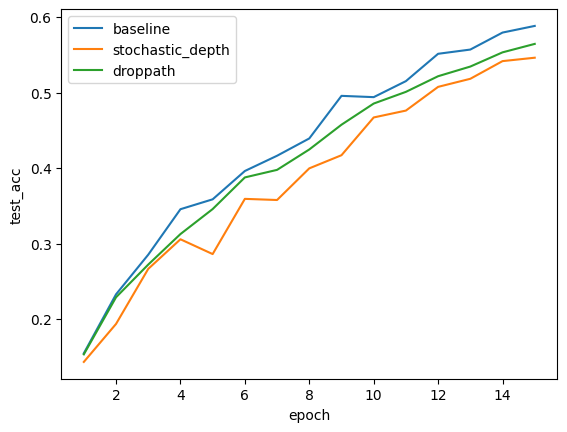

In [20]:
# === 6.3) Plot: Test Acc ===
plt.figure()
for m in modes:
    sub = results[results['mode'] == m]
    plt.plot(sub['epoch'], sub['test_acc'], label=m)
plt.xlabel("epoch")
plt.ylabel("test_acc")
plt.legend()
plt.show()


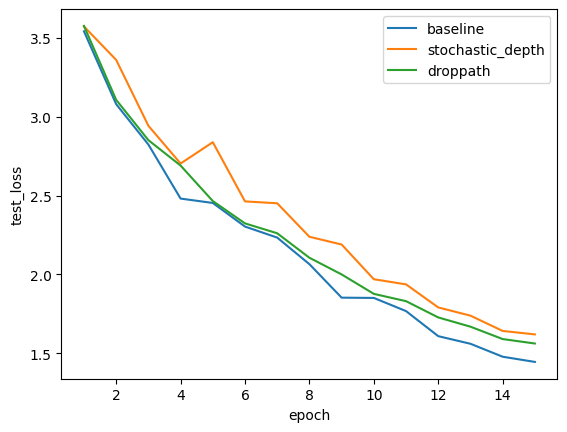

In [21]:
# === 6.4) Plot: Test Loss ===
plt.figure()
for m in modes:
    sub = results[results['mode'] == m]
    plt.plot(sub['epoch'], sub['test_loss'], label=m)
plt.xlabel("epoch")
plt.ylabel("test_loss")
plt.legend()
plt.show()


# 📊 Deney Sonuçlarının Yorumu  
(Baseline vs Stochastic Depth vs DropPath)

## 1️⃣ Final Performans Karşılaştırması (Epoch 15)

| Model | Test Accuracy | Test Loss |
|--------|--------------|-----------|
| Baseline | **0.5882** | **1.4451** |
| DropPath | 0.5644 | 1.5618 |
| Stochastic Depth | 0.5461 | 1.6196 |

### 🔎 Gözlem:
- Bu deneyde **Baseline açık ara en iyi sonucu verdi.**
- Stochastic Depth en düşük performansı verdi.
- DropPath, Stochastic Depth'ten daha iyi ama baseline’dan düşük.

---

## 2️⃣ Overfitting / Underfitting Analizi

Train–Test farkı (genelleme gap):

| Model | Train Acc | Test Acc | Gap |
|--------|-----------|----------|------|
| Baseline | 0.6313 | 0.5882 | 0.0431 |
| Stochastic Depth | 0.5564 | 0.5461 | 0.0103 |
| DropPath | 0.5731 | 0.5644 | 0.0087 |

### 🔎 Yorum:

- Baseline zaten **çok fazla overfit etmiyor** (gap küçük).
- SD ve DropPath gap’i daha da küçültmüş.
- Ancak bu genelleme kazancı değil, **model kapasitesinin düşmesi (underfitting)** gibi görünüyor.

Yani:

> Regularization overfitting'i kırmak yerine öğrenmeyi zorlaştırmış.

---

## 3️⃣ Eğitim Dinamiği Analizi

### İlk Epochlar (1–5)
- SD ve DropPath baştan itibaren baseline’dan daha düşük accuracy gösteriyor.
- Bu, residual branch’in stokastik kapatılmasının öğrenmeyi yavaşlattığını gösteriyor.

### Son Epochlar (10–15)
- Modeller toparlıyor ama baseline’a yetişemiyor.
- Eğitim süresi kısa olduğu için regularization’ın uzun vadeli faydası ortaya çıkmamış olabilir.

---

## 4️⃣ Neden Regularization Zararlı Oldu?

Bu deney koşullarında muhtemel sebepler:

### 🔹 1. Epoch sayısı düşük (15)
Stochastic Depth ve DropPath gibi teknikler genelde:
- Uzun eğitimlerde (50–200 epoch)
- Derin modellerde

daha iyi sonuç verir.

Kısa eğitimde model zaten tam öğrenememişken,
ek regularization öğrenmeyi daha da yavaşlatır.

---

### 🔹 2. Model zaten aşırı overfit etmiyor
Baseline:
- Train Acc = 0.63
- Test Acc = 0.58

Bu değerler zaten aşırı overfit olmadığını gösteriyor.

Regularization’ın asıl faydası:
- Train Acc 0.90+
- Test Acc 0.60 gibi durumlarda ortaya çıkar.

---

### 🔹 3. SD/DropPath agresif olabilir
- p_max yüksek olabilir
- Warmup yeterince dengeli olmayabilir
- Erken katmanlara uygulanması öğrenmeyi bozmuş olabilir

---

## 5️⃣ Genel Sonuç

Bu koşullarda:

- Baseline en iyi sonucu verdi.
- DropPath ve Stochastic Depth overfitting’i azaltıyor.
- Ancak kısa eğitim ve orta derinlikte model için gereksiz regularization olmuş.

### 🎯 Teknik Çıkarım

Bu deney şunu gösteriyor:

> Regularization her zaman performansı artırmaz.  
> Doğru mimari + doğru epoch + doğru kapasite dengesi gerekir.

---

## 6️⃣ Daha Adil Karşılaştırma İçin Öneri

Daha sağlıklı test için:

- Epoch sayısını 50–100 yap
- SD/DropPath oranını düşür
- Sadece derin stage’lerde uygula
- Aynı seed ile birkaç tekrar çalıştır

---

Bu deney, regularization’ın "her zaman kazandırmadığını",  
dozunun ve eğitim süresinin kritik olduğunu net gösteriyor.
